### Vapor Pressure — Aluminum (Al)

> **Antoine form (NIST WebBook):**
> $$\log_{10} P(\mathrm{bar}) = A - \frac{B}{T + C}$$
> where $P$ is vapor pressure in **bar** and $T$ is temperature in **K**.

#### Coefficients (valid for $1557 \le T \le 2329\ \mathrm{K}$)

* $A = 5.73623$
* $B = 13204.109$
* $C = -24.306$

**Reference:** Stull (1947). Coefficients calculated by NIST from author’s data.

[1] https://webbook.nist.gov/cgi/cbook.cgi?ID=C7429905&Units=SI&Mask=4#Thermo-Phase
[2] Stull, Daniel R., Vapor Pressure of Pure Substances. Organic and Inorganic Compounds, Ind. Eng. Chem., 1947, 39, 4, 517-540, https://doi.org/10.1021/ie50448a022


In [ ]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Protocol, Union, Tuple, Optional, runtime_checkable
import numpy as np

ArrayLike = Union[float, np.ndarray]

k_B = 1.380649e-23   # J/K (exact)
N_A = 6.02214076e23  # 1/mol (exact)

def particle_mass_from_molar_mass(M_kg_per_mol: float) -> float:
    """
    Convert molar mass to single-particle mass.

    Definition
    ----------
    Let $M$ be the molar mass in $\mathrm{kg/mol}$ and $N_A$ be Avogadro's number
    in $\mathrm{mol^{-1}}$. The mass of one particle (atom or molecule) is

        $m = M / N_A$.

    Parameters
    ----------
    M_kg_per_mol : float
        Molar mass $M$ in $\mathrm{kg/mol}$.

    Returns
    -------
    float
        Particle mass $m$ in $\mathrm{kg}$ per particle.

    Raises
    ------
    ValueError
        If `M_kg_per_mol <= 0`.

    Notes
    -----
    - This assumes `N_A` is defined in the module scope with units $\mathrm{mol^{-1}}$.
    - Example (Al): $M \\approx 0.0269815\\ \\mathrm{kg/mol}$ gives
      $m \\approx 4.48\\times 10^{-26}\\ \\mathrm{kg}$.

    Examples
    --------
    >>> N_A = 6.02214076e23  # 1/mol
    >>> particle_mass_from_molar_mass(0.01801528)  # water, kg/mol
    2.99e-26  # approximately
    """
    if M_kg_per_mol <= 0.0:
        raise ValueError("M_kg_per_mol must be > 0.")
    return M_kg_per_mol / N_A


# ============================================================
# Base interface (duck-typed)
# ============================================================

@runtime_checkable
class VaporPressureCurve(Protocol):
    """
    Protocol (interface) for a vapor-pressure correlation $P(T)$.

    Purpose
    -------
    This protocol defines the minimal API required by downstream models
    (e.g., Hertz–Knudsen–Langmuir flux) that need an equilibrium vapor pressure
    as a function of temperature.

    Contract
    --------
    Implementations MUST provide:

    1) Metadata (for provenance and validation)
       - `P_unit` : str
           Native unit associated with the correlation parameters
           (e.g., "Pa", "bar", "torr"). This is informational; the canonical
           output is still `P_Pa(...)` in Pascals.
       - `T_unit` : str
           Temperature unit expected by the correlation (typically "K").
       - `valid_range_K` : Optional[Tuple[float, float]]
           If provided, interpreted as $(T_\\min, T_\\max)$ in Kelvin for which
           the correlation is valid.
       - `source` : str
           Human-readable citation/provenance string (e.g., "NIST; Stull (1947)").

    2) Canonical pressure evaluation
       - `P_Pa(T, check_range=True) -> ArrayLike`
           Return equilibrium vapor pressure in Pascals as a function of
           temperature $T$ (Kelvin).

    Parameters
    ----------
    T : ArrayLike
        Temperature(s) in Kelvin. May be a scalar or NumPy array.
    check_range : bool, default=True
        If True and `valid_range_K` is not None, implementations should raise
        a ValueError when any $T$ is outside the stated validity interval.

    Returns
    -------
    ArrayLike
        Equilibrium vapor pressure $P_\\mathrm{eq}(T)$ in Pascals.

    Notes
    -----
    - This is a `typing.Protocol`: it supports duck typing. Any object with
      matching attributes/methods satisfies the protocol.
    - `@runtime_checkable` allows `isinstance(obj, VaporPressureCurve)` to work
      at runtime (useful for debugging and validation), but only checks for the
      presence of attributes/methods—not unit correctness.

    Examples
    --------
    A minimal implementation could be an Antoine correlation class that stores
    coefficients and implements `P_Pa(T)`. Downstream code can then accept any
    such object without depending on the concrete class.
    """
    P_unit: str
    T_unit: str
    valid_range_K: Optional[Tuple[float, float]]
    source: str

    def P_Pa(self, 
             T: ArrayLike, 
             check_range: bool = True
             ) -> ArrayLike:
        ...


# ============================================================
# Mixins / utilities
# ============================================================

@dataclass(frozen=True)
class VaporPressureCurveBase:
    """
    Base class for vapor-pressure correlations.

    Purpose
    -------
    This class provides shared metadata and utility methods for concrete
    vapor-pressure models (e.g., Antoine). Subclasses are expected to implement
    the canonical method:

        `P_Pa(T, check_range=True) -> ArrayLike`

    which returns equilibrium vapor pressure in Pascals.

    Metadata fields
    ---------------
    P_unit : str, default="Pa"
        The *native* pressure unit associated with the correlation parameters
        (e.g., "bar" for some Antoine coefficient tables). This is primarily
        provenance/annotation. The canonical output of `P_Pa(...)` is always Pa.
    T_unit : str, default="K"
        Temperature unit expected by the correlation (typically Kelvin).
    valid_range_K : Optional[Tuple[float, float]], default=None
        Validity range $(T_\\min, T_\\max)$ in Kelvin for the correlation.
        If provided and `check_range=True`, temperatures outside this interval
        should raise a ValueError.
    source : str, default="unknown"
        Human-readable citation/provenance string for the correlation.

    Notes
    -----
    - This base class does *not* define `P_Pa` itself; it assumes subclasses
      provide it. The method `P(...)` calls `self.P_Pa(...)`.
    - `_convert_pressure` intentionally supports only a small set of units
      ("Pa", "bar", "torr") to keep the core lightweight. Extend as needed.

    """

    P_unit: str = "Pa"
    T_unit: str = "K"
    valid_range_K: Optional[Tuple[float, float]] = None
    source: str = "unknown"

    def _check_T(self, T: np.ndarray, check_range: bool) -> None:
        """
        Validate temperatures for correlation evaluation.

        Parameters
        ----------
        T : np.ndarray
            Temperature values in Kelvin.
        check_range : bool
            If True and `valid_range_K` is provided, enforce the validity range.

        Raises
        ------
        ValueError
            If any temperature is non-positive, or (optionally) outside the
            validity interval.
        """
        if np.any(T <= 0):
            raise ValueError("T must be > 0 K.")
        if check_range and self.valid_range_K is not None:
            Tmin, Tmax = self.valid_range_K
            if np.any(T < Tmin) or np.any(T > Tmax):
                raise ValueError(f"T outside validity range [{Tmin}, {Tmax}] K.")

    @staticmethod
    def _convert_pressure(P: np.ndarray, from_unit: str, to_unit: str) -> np.ndarray:
        """
        Convert pressure between supported units.

        Supported units
        ---------------
        - "Pa"   : Pascal
        - "bar"  : 1 bar = 1e5 Pa
        - "torr" : 1 torr = 133.322368 Pa

        Parameters
        ----------
        P : np.ndarray
            Pressure values in `from_unit`.
        from_unit : str
            Unit label for the input pressure.
        to_unit : str
            Unit label for the output pressure.

        Returns
        -------
        np.ndarray
            Pressure values converted to `to_unit`.

        Raises
        ------
        ValueError
            If either unit is unsupported.
        """
        from_unit = from_unit.lower()
        to_unit = to_unit.lower()

        # Convert input -> Pa
        if from_unit == "pa":
            P_pa = P
        elif from_unit == "bar":
            P_pa = P * 1e5
        elif from_unit == "torr":
            P_pa = P * 133.322368
        else:
            raise ValueError(f"Unsupported from_unit: {from_unit}")

        # Convert Pa -> target
        if to_unit == "pa":
            return P_pa
        elif to_unit == "bar":
            return P_pa / 1e5
        elif to_unit == "torr":
            return P_pa / 133.322368
        else:
            raise ValueError(f"Unsupported to_unit: {to_unit}")

    def P(self, T: ArrayLike, unit: str = "Pa", check_range: bool = True) -> ArrayLike:
        r"""
        Evaluate vapor pressure and return it in a requested unit.

        This is a convenience wrapper around the subclass-provided `P_Pa(...)`.

        Parameters
        ----------
        T : ArrayLike
            Temperature(s) in Kelvin.
        unit : str, default="Pa"
            Desired output pressure unit ("Pa", "bar", or "torr").
        check_range : bool, default=True
            Forwarded to `P_Pa(...)`. If True, enforce `valid_range_K` when
            available.

        Returns
        -------
        ArrayLike
            Vapor pressure $P(T)$ in the requested unit.

        Notes
        -----
        - Canonical evaluation is done in Pascals via `P_Pa(...)`, then converted.
        """
        P_pa = np.asarray(self.P_Pa(T, check_range=check_range), dtype=float)
        return self._convert_pressure(P_pa, "Pa", unit)


# ============================================================
# Antoine curve implementation
# ============================================================

@dataclass(frozen=True)
class VaporPressureAntoineCurve(VaporPressureCurveBase):
    r"""
    Antoine vapor-pressure correlation (base-10).

    Model
    -----
    The Antoine form used here is

        $$\log_{10} P = A - \frac{B}{T + C}$$

    where:
    - $T$ is temperature in Kelvin,
    - $P$ is vapor pressure in the *native* pressure unit `P_unit`
      (often "bar" for NIST-tabulated coefficients).

    Canonical output
    ----------------
    This class defines `P_Pa(T)` as the canonical evaluation method required by
    `VaporPressureCurve`. It converts the native Antoine pressure to Pascals.

    Parameters
    ----------
    A, B, C : float
        Antoine coefficients for the specified unit convention.
        These values are *not* universal; they depend on the chosen units of
        pressure and temperature and on the data source.
    P_unit : str, default="bar"
        The pressure unit implied by the coefficients (`A`, `B`, `C`).
        Supported conversions in the base class: "Pa", "bar", "torr".

    Inherited metadata
    ------------------
    valid_range_K : Optional[Tuple[float, float]]
        If provided and `check_range=True`, evaluation outside the interval
        raises `ValueError`.
    source : str
        Citation/provenance for the coefficients.

    Methods
    -------
    log10P_native(T, check_range=True)
        Return $\log_{10} P$ where $P$ is in `P_unit`.
    P_native(T, check_range=True)
        Return $P$ in `P_unit`.
    P_Pa(T, check_range=True)
        Return $P$ in Pascals.

    Raises
    ------
    ValueError
        - If any $T \le 0$ K.
        - If `valid_range_K` is set and $T$ is outside it (when `check_range=True`).
        - If $T + C = 0$ for any entry (Antoine singularity).
        - If `P_unit` is unsupported for conversion.

    Notes
    -----
    - The Antoine correlation is empirical. Do not extrapolate outside the stated
      validity range unless you accept uncontrolled error.
    - The singularity at $T = -C$ is mathematical; it may lie outside the valid
      range for physically meaningful coefficients.

    Examples
    --------
    >>> Al_vp = VaporPressureAntoineCurve(
    ...     A=5.73623, B=13204.109, C=-24.306,
    ...     P_unit="bar", valid_range_K=(1557.0, 2329.0),
    ...     source="NIST WebBook; Stull (1947)"
    ... )
    >>> Al_vp.P_Pa(1800.0)
    123.4  # (example magnitude; actual value depends on coefficients)
    """

    A: float = 0.0
    B: float = 0.0
    C: float = 0.0
    P_unit: str = "bar"  # native unit for Antoine coefficients

    def log10P_native(self, 
                      T: ArrayLike, 
                      check_range: bool = True
                      ) -> ArrayLike:
        """
        Evaluate $\log_{10} P$ in the native pressure units `P_unit`.

        Parameters
        ----------
        T : ArrayLike
            Temperature(s) in Kelvin.
        check_range : bool, default=True
            If True, enforce `valid_range_K` when available.

        Returns
        -------
        ArrayLike
            $\log_{10} P$ where $P$ is expressed in `P_unit`.

        Raises
        ------
        ValueError
            If $T \le 0$ K, outside validity range (optional), or $T + C = 0$.
        """
        T = np.asarray(T, dtype=float)
        self._check_T(T, check_range=check_range)

        if np.any((T + self.C) == 0):
            raise ValueError("Singularity: T + C = 0 in Antoine form.")
        return self.A - self.B / (T + self.C)

    def P_native(self, 
                 T: ArrayLike, 
                 check_range: bool = True
                 ) -> ArrayLike:
        """
        Evaluate vapor pressure $P(T)$ in the native units `P_unit`.

        Parameters
        ----------
        T : ArrayLike
            Temperature(s) in Kelvin.
        check_range : bool, default=True
            If True, enforce `valid_range_K` when available.

        Returns
        -------
        ArrayLike
            Vapor pressure $P$ in `P_unit`.
        """
        return 10.0 ** self.log10P_native(T, check_range=check_range)

    def P_Pa(self, 
             T: ArrayLike, 
             check_range: bool = True
             ) -> ArrayLike:
        """
        Evaluate vapor pressure and return it in Pascals.

        Parameters
        ----------
        T : ArrayLike
            Temperature(s) in Kelvin.
        check_range : bool, default=True
            If True, enforce `valid_range_K` when available.

        Returns
        -------
        ArrayLike
            Vapor pressure $P(T)$ in Pascals (Pa).
        """
        P_native = np.asarray(
            self.P_native(T, check_range=check_range),
            dtype=float
            )
        return self._convert_pressure(P_native, self.P_unit, "Pa")


@dataclass(frozen=True)
class NumberFluxHertzKnudsenLangmuir:
    r"""
    Hertz-Knudsen-Langmuir number flux from an evaporating surface.

    Model
    -----
    For a species of particle mass $m$ in equilibrium with a vapor of partial
    pressure $P$, the one-way molecular emission (number) flux is

        $$\Phi(T) = \alpha \frac{P_\mathrm{net}(T)}{\sqrt{2\pi m k_B T}},$$

    where:
    - $k_B$ is Boltzmann's constant,
    - $\alpha$ is the evaporation (or condensation) coefficient,
    - $P_\mathrm{net}(T) = \max(P_\mathrm{eq}(T) - P_\mathrm{bg},\,0)$,
    - $P_\mathrm{eq}(T)$ is the equilibrium vapor pressure at the surface,
    - $P_\mathrm{bg}$ is an optional background partial pressure of the same species.

    Units
    -----
    - $P_\mathrm{eq}$, $P_\mathrm{bg}$ : Pa
    - $m$ : kg per particle (atom or molecule)
    - $T$ : K
    - $\Phi$ : $\mathrm{m^{-2}\,s^{-1}}$ (number flux)

    Parameters
    ----------
    vapor_pressure : VaporPressureCurve
        Correlation object providing `P_Pa(T)` for the equilibrium vapor
        pressure $P_\mathrm{eq}(T)$ in Pascals.
    m_kg : float
        Particle mass $m$ in kg (per atom or per molecule). For a molar mass $M$,
        use $m = M/N_A$.
    alpha : float, default=1.0
        Evaporation/condensation coefficient $\alpha \ge 0$.
        Typical simplified models use $\alpha \approx 1$, but in reality it may
        be temperature-, surface-, and species-dependent.
    P_bg_Pa : float, default=0.0
        Background partial pressure $P_\mathrm{bg}$ in Pa. If nonzero, the model
        returns a *net* emission flux reduced by return flux. Negative driving
        pressure is clamped to zero.

    Notes
    -----
    - This model computes a **one-way** emission flux when `P_bg_Pa = 0`.
      Setting `P_bg_Pa > 0` approximates a reduced *net* flux.
    - The clamp `max(P_eq - P_bg, 0)` prevents unphysical negative emission flux.
      If you want bidirectional behavior, remove the clamp and interpret the
      sign as direction (but then you must be consistent about what “negative”
      means in your downstream code).
    - The name `Phi` is used here to emphasize *number flux*.
        - $\Phi$ : number flux (particles / area / time)
        - $\Gamma$ : mass flux (kg / area / time)

    Raises
    ------
    ValueError
        If any temperature is non-positive, if `m_kg <= 0`, if `alpha < 0`,
        or if `P_bg_Pa < 0`.

    Examples
    --------
    >>> m_Al = particle_mass_from_molar_mass(0.0269815385)
    >>> phi = NumberFluxHertzKnudsenLangmuir(vapor_pressure=Al_vp, m_kg=m_Al)
    >>> phi.Phi(1800.0)  # 1/(m^2 s)
    1.23e22  # example magnitude
    """

    vapor_pressure: VaporPressureCurve
    m_kg: float
    alpha: float = 1.0
    P_bg_Pa: float = 0.0  # optional background partial pressure

    def Phi(self, T: ArrayLike, check_range: bool = True) -> ArrayLike:
        """
        Evaluate the Hertz-Knudsen-Langmuir number flux.

        Parameters
        ----------
        T : ArrayLike
            Temperature(s) in Kelvin.
        check_range : bool, default=True
            Forwarded to `vapor_pressure.P_Pa(...)`. If True and the vapor
            pressure model declares a validity range, out-of-range $T$ should
            raise `ValueError`.

        Returns
        -------
        ArrayLike
            Number flux $\Phi(T)$ in $\mathrm{m^{-2}\,s^{-1}}$.

        Raises
        ------
        ValueError
            If $T \le 0$, `m_kg <= 0`, `alpha < 0`, or `P_bg_Pa < 0`.
        """
        T = np.asarray(T, dtype=float)

        if np.any(T <= 0):
            raise ValueError("T must be > 0 K.")
        if self.alpha < 0.0:
            raise ValueError("alpha must be >= 0.")
        if self.m_kg <= 0.0:
            raise ValueError("m_kg must be > 0.")
        if self.P_bg_Pa < 0.0:
            raise ValueError("P_bg_Pa must be >= 0.")

        P_eq = np.asarray(self.vapor_pressure.P_Pa(T, check_range=check_range), dtype=float)
        P_net = np.maximum(P_eq - self.P_bg_Pa, 0.0)

        denom = np.sqrt(2.0 * np.pi * self.m_kg * k_B * T)
        return self.alpha * P_net / denom


@dataclass(frozen=True)
class MassFluxHertzKnudsenLangmuir:
    r"""
    Hertz-Knudsen-Langmuir mass flux (wrapper around number flux).

    Model
    -----
    Given the HKL number flux $\Phi(T)$ (particles per area per time), the mass
    flux is

        $$\Gamma(T) = m\,\Phi(T),$$

    where $m$ is the mass per particle (atom or molecule). This produces a mass
    flux in $\mathrm{kg\,m^{-2}\,s^{-1}}$.

    Units
    -----
    - $\Phi$ : $\mathrm{m^{-2}\,s^{-1}}$
    - $m$ : kg per particle
    - $\Gamma$ : $\mathrm{kg\,m^{-2}\,s^{-1}}$

    Parameters
    ----------
    number_flux : NumberFluxHertzKnudsenLangmuir
        Instance providing the HKL number flux $\Phi(T)$ and the particle mass
        `m_kg`.

    Notes
    -----
    - This wrapper deliberately does not re-implement pressure/temperature logic.
      It delegates to `number_flux.Phi(...)` and multiplies by `m_kg`.
    - Nomenclature commonly used in thin-film texts:
        - $\Phi$ : number flux
        - $\Gamma$ : mass flux
      (Different authors sometimes swap symbols; your code fixes the meaning by
      method name: `Phi` vs `Gamma`.)

    Examples
    --------
    >>> phi = NumberFluxHertzKnudsenLangmuir(vapor_pressure=Al_vp, m_kg=m_Al)
    >>> Gamma = MassFluxHertzKnudsenLangmuir(phi)
    >>> Gamma.Gamma(1800.0)  # kg/(m^2 s)
    1.23e-3  # example magnitude
    >>> Gamma(1800.0)        # same as Gamma.Gamma(...)
    1.23e-3
    """

    number_flux: NumberFluxHertzKnudsenLangmuir

    def Gamma(self, 
              T: ArrayLike, 
              check_range: bool = True) -> ArrayLike:
        """
        Evaluate the HKL mass flux.

        Parameters
        ----------
        T : ArrayLike
            Temperature(s) in Kelvin.
        check_range : bool, default=True
            Forwarded to `number_flux.Phi(...)` (and then to the underlying
            vapor-pressure correlation). If True, enforce validity ranges when
            available.

        Returns
        -------
        ArrayLike
            Mass flux $\Gamma(T)$ in $\mathrm{kg\,m^{-2}\,s^{-1}}$.
        """
        return self.number_flux.m_kg * self.number_flux.Phi(T, check_range=check_range)

    def __call__(self, T: ArrayLike, check_range: bool = True) -> ArrayLike:
        """
        Callable shorthand for `Gamma(T, ...)`.
        """
        return self.Gamma(T, check_range=check_range)

@dataclass(frozen=True)
class PointSourceDeposition:
    """
    Point-source propagation:
        J_s = (dotM_e / (4π r^2)) * max(0, n·Rhat)
    """
    r_e: np.ndarray  # (3,) source position [m]

    def cos_theta(self, 
                  r_s: np.ndarray, 
                  n_s: np.ndarray
                  ) -> np.ndarray:
        R = r_s - self.r_e
        r = np.linalg.norm(R, axis=-1)
        Rhat = R / r[..., None]
        n_s = n_s / np.linalg.norm(n_s, axis=-1)[..., None]
        c = np.sum(n_s * Rhat, axis=-1)
        return np.maximum(c, 0.0)

    def J_mass(self, 
               r_s: np.ndarray, 
               n_s: np.ndarray, 
               dotM_e: float) -> np.ndarray:
        R = r_s - self.r_e
        r = np.linalg.norm(R, axis=-1)
        c = self.cos_theta(r_s, n_s)
        return (dotM_e / (4.0 * np.pi * r**2)) * c  # kg/(m^2 s)

    def thickness_rate(self, 
                       r_s: np.ndarray, 
                       n_s: np.ndarray, 
                       dotM_e: float, 
                       rho_f: float) -> np.ndarray:
        return self.J_mass(r_s, n_s, dotM_e) / rho_f  # m/s



In [2]:
# ============================================================
# Example: Aluminum (NIST; Stull 1947) in bar, T in K
# ============================================================

Al_vp: VaporPressureCurve = VaporPressureAntoineCurve(
    A=5.73623,
    B=13204.109,
    C=-24.306,
    P_unit="bar",
    T_unit="K",
    valid_range_K=(1557.0, 2329.0),
    source="NIST WebBook; Stull (1947)",
)

# Usage:
#   P_pa   = Al_vp.P_Pa(1800.0)
#   P_torr = Al_vp.P(1800.0, unit="torr")


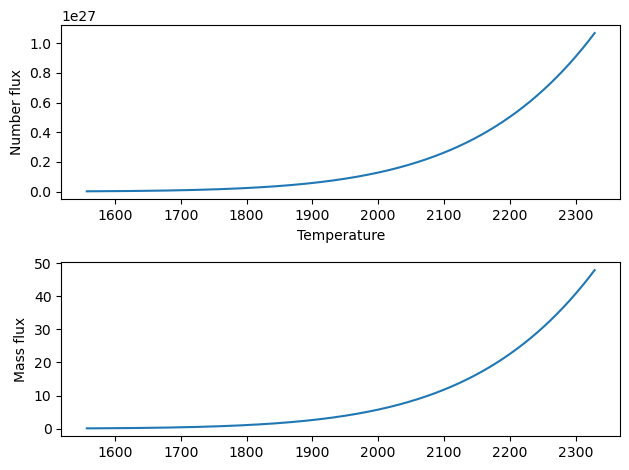

In [16]:
m_kg = particle_mass_from_molar_mass(0.0269815385)
phi_hkl = NumberFluxHertzKnudsenLangmuir(Al_vp, m_kg, alpha=1.0, P_bg_Pa = 0)  # alpha=1, P_bg=0 default
gamma_hkl = MassFluxHertzKnudsenLangmuir(number_flux=phi_hkl)

T_arr = np.linspace(1557, 2329, 1000)
phi_arr = phi_hkl.Phi(T=T_arr)

import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(T_arr, phi_hkl.Phi(T_arr))
ax[0].set_ylabel("Number flux")
ax[0].set_xlabel("Temperature")
ax[1].plot(T_arr, gamma_hkl.Gamma(T_arr))
ax[1].set_ylabel("Mass flux")
ax[0].set_xlabel("Temperature")
fig.tight_layout()



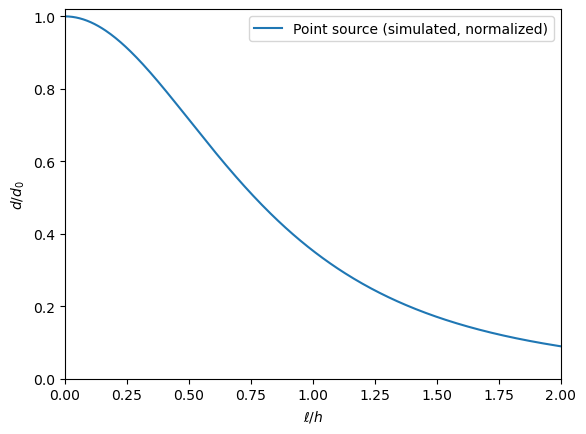

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Reuse the already-defined objects and functions from prior cell execution if available.
# To be robust in isolation, define the analytic curve and plot using provided outputs.

# If x and d_ratio exist from prior steps, use them; otherwise compute quickly.
try:
    x
    d_ratio
except NameError:
    # Minimal fallback using analytic relation; this should not happen in this environment.
    x = np.linspace(0.0, 2.0, 401)
    d_ratio = (1.0 + x**2)**(-1.5)

plt.figure()
plt.plot(x, d_ratio, label="Point source (simulated, normalized)")
plt.xlabel(r"$\ell/h$")
plt.ylabel(r"$d/d_0$")
plt.xlim(0, 2.0)
plt.ylim(0, 1.02)
plt.legend()
plt.show()



In [4]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Union
import numpy as np

ArrayLike = Union[float, np.ndarray]

@dataclass(frozen=True)
class SubstratePlanePointSource:
    """
    Flat substrate (plane) + point source below it (Ohring-style geometry).

    Coordinates:
      - substrate plane at z = 0
      - point source at (0, 0, -h)

    A substrate point is parameterized by its lateral offset ell >= 0.
    """
    h_m: float  # source-to-plane distance [m]

    def r(self, 
          ell_m: ArrayLike) -> ArrayLike:
        ell_m = np.asarray(ell_m, dtype=float)
        return np.sqrt(self.h_m**2 + ell_m**2)

    def cos_theta(self, ell_m: ArrayLike) -> ArrayLike:
        # angle between substrate normal (+z) and incoming ray
        return self.h_m / self.r(ell_m)

    def mass_flux(self, ell_m: ArrayLike, dotM_e_kg_s: float) -> ArrayLike:
        r = self.r(ell_m)
        return (dotM_e_kg_s / (4.0 * np.pi * r**2)) * self.cos_theta(ell_m)

    def thickness_rate(self, 
                       ell_m: ArrayLike, 
                       dotM_e_kg_s: float, 
                       rho_f_kg_m3: float) -> ArrayLike:
        return self.mass_flux(ell_m, dotM_e_kg_s) / rho_f_kg_m3

    def thickness_ratio(self, ell_over_h: ArrayLike) -> ArrayLike:
        x = np.asarray(ell_over_h, dtype=float)
        return (1.0 + x**2) ** (-1.5)


In [ ]:
def substrate_line_points(ell: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Points along x-axis on substrate plane z=0, with constant upward normal.
    ell: (N,) lateral offsets [m]
    returns:
      r_s: (N,3)
      n_s: (N,3)
    """
    ell = np.asarray(ell, dtype=float)
    r_s = np.stack([ell, np.zeros_like(ell), np.zeros_like(ell)], axis=1)
    n_s = np.tile(np.array([[0.0, 0.0, 1.0]]), (ell.size, 1))
    return r_s, n_s

def simulate_point_source_profile(
    T: float,
    vp: VaporPressureCurve,
    m_kg: float,
    A_e: float,         # m^2
    h: float,           # m
    rho_f: float,       # kg/m^3
    ell: np.ndarray,    # m
    alpha: float = 1.0,
    P_bg_Pa: float = 0.0,
):
    # HKL
    phi = NumberFluxHertzKnudsenLangmuir(
        vapor_pressure=vp,
        m_kg=m_kg, 
        alpha=alpha, 
        P_bg_Pa=P_bg_Pa)
    Gamma = MassFluxHertzKnudsenLangmuir(phi).Gamma(T)      # kg/(m^2 s)
    dotM_e = A_e * float(Gamma)                             # kg/s

    # geometry
    dep = PointSourceDeposition(r_e=np.array([0.0, 0.0, -h]))
    r_s, n_s = substrate_line_points(ell)
    d_dot = dep.thickness_rate(r_s, n_s, dotM_e=dotM_e, rho_f=rho_f)  # m/s

    # normalized profile (matches book plot)
    d_ratio = d_dot / d_dot[0]
    x = ell / h
    return x, d_ratio, d_dot, dotM_e

# Al vapor pressure object (you already have Al_vp)
m_Al = particle_mass_from_molar_mass(0.0269815385)

T = 1800.0
h = 0.20
ell = np.linspace(0.0, 2.0*h, 401)   # so ell/h goes 0..2
A_e = 1e-4                           # 1 cm^2 effective area (placeholder)
rho_f = 2700.0                       # kg/m^3 (placeholder)

x, d_ratio, d_dot, dotM_e = simulate_point_source_profile(  
    T=T, vp=Al_vp, m_kg=m_Al, A_e=A_e, h=h, rho_f=rho_f, ell=ell
)


In [10]:
from __future__ import annotations
from dataclasses import dataclass
import numpy as np

@dataclass(frozen=True)
class SurfaceSourceDiskDeposition:
    """
    Finite surface source: emitting disk (radius a) in plane z=-h, centered on axis.
    Substrate plane: z=0, normal +z.
    Emission law: intensity ∝ cos^n(phi) about the +z source normal.
    """

    h: float          # m, source plane to substrate plane separation
    a: float          # m, disk radius
    n: float = 1.0    # cosine-power exponent (Lambertian ~ 1)

    def _integrand_r_pow(self, ell: np.ndarray, rho: np.ndarray, psi: np.ndarray) -> np.ndarray:
        """
        Returns r^(-(n+3)) evaluated for (ell, rho, psi).
        ell: (Ne,) lateral offsets on substrate (x-axis)
        rho: (Nr,) radial coordinates on source disk
        psi: (Npsi,) azimuth on source disk
        Output: (Ne, Nr, Npsi)
        """
        # Broadcast to (Ne, Nr, Npsi)
        ell = ell[:, None, None]
        rho = rho[None, :, None]
        psi = psi[None, None, :]

        r2 = (ell**2 + rho**2 - 2.0*ell*rho*np.cos(psi) + self.h**2)
        r = np.sqrt(r2)
        return r ** (-(self.n + 3.0))

    def J_shape(self, ell: np.ndarray, Nr: int = 250, Npsi: int = 360) -> np.ndarray:
        """
        Returns J_s(ell) up to a multiplicative constant (the constant cancels in normalization).
        """
        ell = np.asarray(ell, dtype=float)

        # polar grid on source disk
        rho = np.linspace(0.0, self.a, Nr)
        psi = np.linspace(0.0, 2.0*np.pi, Npsi, endpoint=False)

        # dA = rho d rho d psi
        # Integrand: h^(n+1) * r^(-(n+3)) * rho
        rpow = self._integrand_r_pow(ell, rho, psi)
        integrand = (self.h ** (self.n + 1.0)) * rpow * rho[None, :, None]

        # integrate over psi then rho
        dpsi = 2.0*np.pi / Npsi
        drho = self.a / (Nr - 1) if Nr > 1 else 0.0

        J_psi = np.sum(integrand, axis=2) * dpsi         # (Ne, Nr)
        J = np.sum(J_psi, axis=1) * drho                 # (Ne,)
        return J

    def thickness_ratio(self, ell_over_h: np.ndarray, Nr: int = 250, Npsi: int = 360) -> np.ndarray:
        """
        Returns normalized thickness profile d/d0 vs x = ell/h.
        """
        x = np.asarray(ell_over_h, dtype=float)
        ell = x * self.h
        J = self.J_shape(ell, Nr=Nr, Npsi=Npsi)
        return J / J[0]


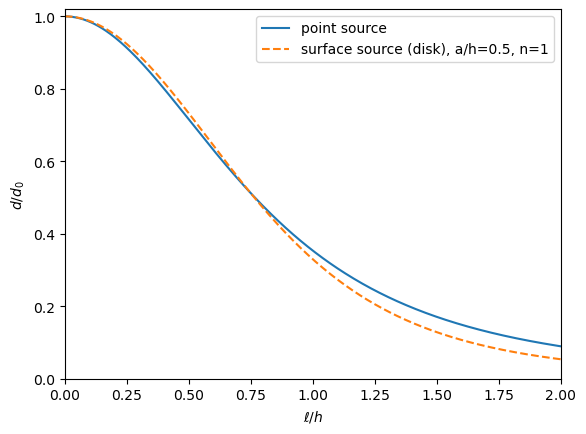

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# reuse your point-source result:
# x, d_ratio, d_dot, dotM_e = simulate_point_source_profile(...)

# choose surface-source parameters
a_over_h = 0.5      # change this; controls how fast the dashed curve drops
n = 1.0             # Lambertian
surf = SurfaceSourceDiskDeposition(h=h, a=a_over_h*h, n=n)

d_ratio_surface = surf.thickness_ratio(x, Nr=250, Npsi=360)

plt.figure()
plt.plot(x, d_ratio, label="point source")
plt.plot(x, d_ratio_surface, "--", label=f"surface source (disk), a/h={a_over_h}, n={n:g}")
plt.xlabel(r"$\ell/h$")
plt.ylabel(r"$d/d_0$")
plt.xlim(0, 2.0)
plt.ylim(0, 1.02)
plt.legend()
plt.show()


NameError: name 'AffineCalibrator' is not defined

notebook


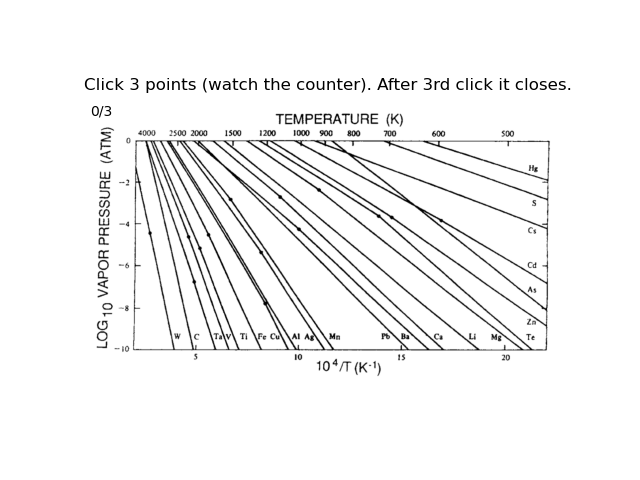

calib_pix: []


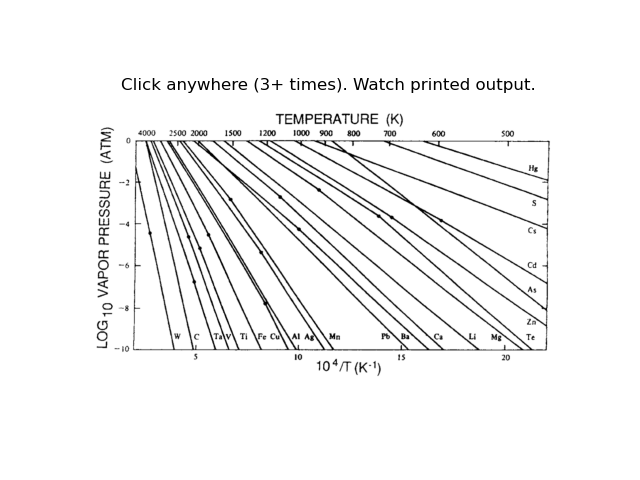

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib widget

img_path = os.path.join(
    "img",
    "ohring2ed_fig3.1.png"
)
img = mpimg.imread(img_path)

fig, ax = plt.subplots()
ax.imshow(img, cmap="gray" if img.ndim == 2 else None)
ax.set_title("Click anywhere (3+ times). Watch printed output.")
ax.axis("off")

def on_click(event):
    print("button:", event.button, "inaxes:", event.inaxes is not None,
          "xdata:", event.xdata, "ydata:", event.ydata)

cid = fig.canvas.mpl_connect("button_press_event", on_click)
plt.show()


widget


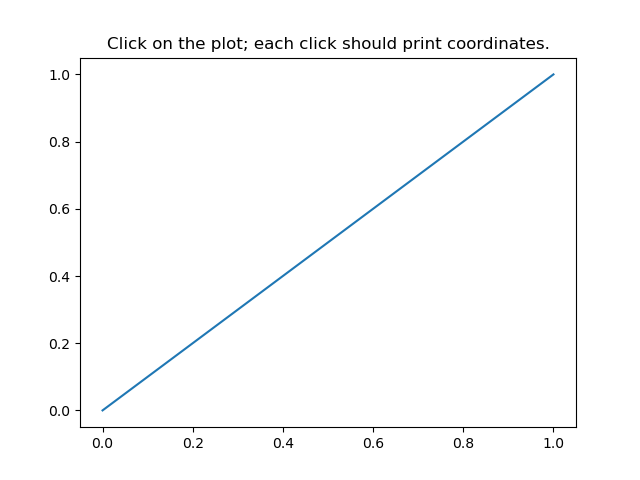

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.get_backend())

fig, ax = plt.subplots()
ax.plot([0,1],[0,1])
ax.set_title("Click on the plot; each click should print coordinates.")

def on_click(event):
    print("clicked:", event.xdata, event.ydata)

cid = fig.canvas.mpl_connect("button_press_event", on_click)
plt.show()
